# Part 0: Load packages and Read in Data

In [73]:
# load packages
%matplotlib inline
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns
import sklearn as sl
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Read in data
* 'Video_id' is defined as the index of each movie. 'cvt_per_day' is the metric, which is defined as cumulative time viewed by audiences per day. The rest of 14 columns are all characteristic features (numeric & categorical) of each video.
* There are 4226 rows and 16 columns in the dataset. 

In [2]:
df = pd.read_table('TVdata.txt', sep = ',', header=0, lineterminator = '\n')
df.head()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,import_id,release_year,genres,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,awards,mpaa,star_category
0,385504,307127.606,1,3,lionsgate,2013,"Action,Thriller,Drama",69614,15000000,42930462,6.500,112.301,51,other award,PG-13,1.710
1,300175,270338.426,1,3,lionsgate,2013,"Comedy,Crime,Thriller",46705,15000000,3301046,6.500,94.983,41,no award,R,3.250
2,361899,256165.867,1,3,other,2012,"Crime,Drama",197596,26000000,37397291,7.300,115.764,58,other award,R,2.647
3,308314,196622.721,3,4,lionsgate,2008,"Thriller,Drama,War,Documentary,Mystery,Action",356339,15000000,15700000,7.600,130.704,94,Oscar,R,1.667
4,307201,159841.652,1,3,lionsgate,2013,"Crime,Thriller,Mystery,Documentary",46720,27220000,8551228,6.400,105.546,37,other award,R,3.067


In [3]:
print('Number of rows: ' + str(df.shape[0]))
print('Number of columns: ' + str(df.shape[1]))

Number of rows: 4226
Number of columns: 16


# Part 1: Data Exploration

## 1.1 Remove Duplication
* This step checks and removes any duplicate entries, given the assumption that each movie should only appear once in the dataset. 

In [4]:
# check duplicated entry
duplicated = len(df.set_index('video_id').index.get_duplicates()) 
print('There is {} duplicated entry (video_id based).'.format(duplicated))

There is 0 duplicated entry (video_id based).


## 1.2 Check column attributes
* This step is important as we want to know whether a variable is numeric or categorical.

In [9]:
df.dtypes

video_id                           int64
cvt_per_day                      float64
weighted_categorical_position      int64
weighted_horizontal_poition        int64
import_id                         object
release_year                       int64
genres                            object
imdb_votes                         int64
budget                             int64
boxoffice                          int64
imdb_rating                      float64
duration_in_mins                 float64
metacritic_score                   int64
awards                            object
mpaa                              object
star_category                    float64
dtype: object

## 1.3 Exploratory analysis: numerical variables
### 1.3.1 Overview
* First, use descriptive statistics (mean, std, percentiles, min, max...) to describe the numeric variables.  
* Note: video_id, release_year are not numeric variables although they are represented by numbers.

In [5]:
df.drop(['video_id', 'release_year'],axis=1).describe(percentiles = [.1, .25, .5, .75, .95])

,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category
count,4226.000,4226.000,4226.000,4226.000,4226.000,4226.000,4226.000,4226.000,4226.000,4226.000
mean,4218.630,7.783,28.104,6462.924,2150743.439,2536338.472,5.257,89.556,15.974,0.955
std,13036.080,6.134,11.864,31596.007,7176604.483,8243516.266,2.123,21.086,26.205,0.955
min,2.188,1.000,1.000,0.000,0.000,0.000,0.000,4.037,0.000,0.000
10%,141.985,3.000,13.000,8.000,0.000,0.000,2.300,62.391,0.000,0.000
25%,351.169,4.000,20.000,81.000,0.000,0.000,4.300,82.602,0.000,0.000
50%,1193.500,6.000,28.000,535.000,0.000,0.000,5.800,90.730,0.000,1.000
75%,3356.789,9.000,36.000,3053.000,1500000.000,0.000,6.800,99.500,41.000,1.667
95%,14692.834,22.000,48.000,26199.500,12000000.000,8551228.000,7.800,119.131,65.000,2.597
max,307127.606,41.000,70.000,948630.000,107000000.000,184208848.000,10.000,246.017,100.000,4.000


* Second, check missing data. 

In [7]:
print((df == 0).sum())

video_id                            0
cvt_per_day                         0
weighted_categorical_position       0
weighted_horizontal_poition         0
import_id                           0
release_year                        0
genres                              0
imdb_votes                        344
budget                           2454
boxoffice                        3194
imdb_rating                       344
duration_in_mins                    0
metacritic_score                 3012
awards                              0
mpaa                                0
star_category                    1846
dtype: int64


Among the numerical variables (not including video_id and release_year), 4 variables have more than 25% of missing data: budget, boxoffice, metacritic_score, star_category. 2 variables have less than 10% of missing data: imdb_votes, imdb_rating.

### 1.3.2 Response Variable 
* 'cvt_per_day' is considered as the response variable in the dataset.

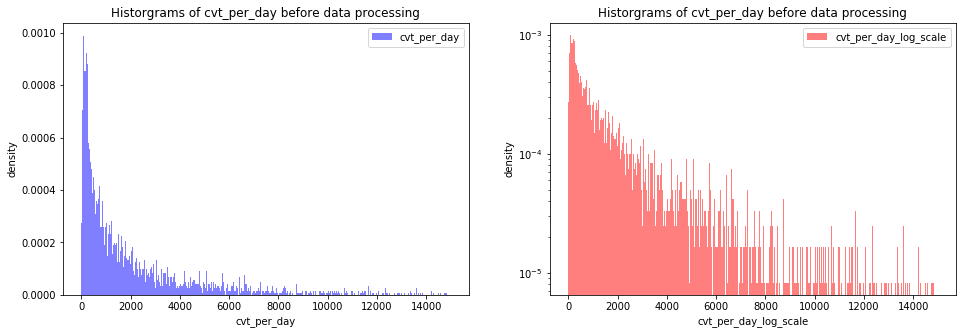

In [8]:
fig=plt.figure(figsize=(16,5))
ax0=fig.add_subplot(121)
ax0.hist(df['cvt_per_day'].values, bins = range(0,15000, 30), alpha = 0.5, color='b', label = 'cvt_per_day', normed = True)
ax0.legend(loc ='upper right')
ax0.set_title('Historgrams of cvt_per_day before data processing')
ax0.set_xlabel('cvt_per_day')
ax0.set_ylabel('density')

# log scale of y due to large variation
ax1=fig.add_subplot(122)
ax1.hist(df['cvt_per_day'].values, log = True, bins = range(0,15000, 30), alpha = 0.5, color='r', label = 'cvt_per_day_log_scale', normed = True)
ax1.legend(loc ='upper right')
ax1.set_title('Historgrams of cvt_per_day before data processing')
ax1.set_xlabel('cvt_per_day_log_scale')
ax1.set_ylabel('density')

plt.show()

We can see from the left plot that the distribution of the response variable, cvt_per_day, is pretty right skewed. So we applied a log transformation to the response variable then plot its distribution. The right plot shows that the log transformed response variable remains skewed. 

### 1.3.3 Correlation between response variable and other numetric variables

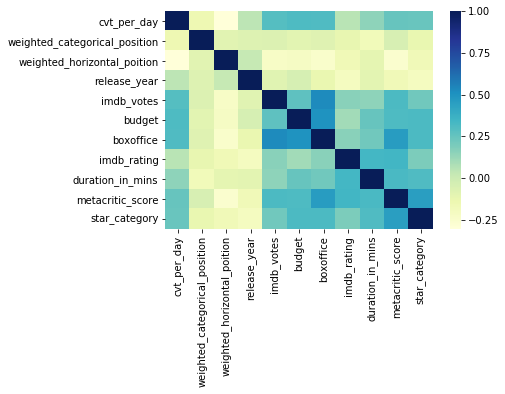

In [9]:
# correlation of the numerical features 
corr = df[['cvt_per_day','weighted_categorical_position','weighted_horizontal_poition'
               ,'release_year', 'imdb_votes', 'budget', 'boxoffice' ,'imdb_rating', 
               'duration_in_mins', 'metacritic_score', 'star_category']].corr()

sns.heatmap(corr, cmap="YlGnBu")

In [10]:
corr

,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,release_year,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,star_category
cvt_per_day,1.000,-0.148,-0.302,0.046,0.298,0.316,0.312,0.059,0.152,0.249,0.247
weighted_categorical_position,-0.148,1.000,-0.084,-0.069,-0.064,-0.090,-0.074,-0.116,-0.174,-0.044,-0.123
weighted_horizontal_poition,-0.302,-0.084,1.000,0.027,-0.221,-0.211,-0.245,-0.162,-0.102,-0.255,-0.168
release_year,0.046,-0.069,0.027,1.000,-0.083,-0.040,-0.128,-0.199,-0.097,-0.167,-0.198
imdb_votes,0.298,-0.064,-0.221,-0.083,1.000,0.273,0.531,0.163,0.156,0.322,0.225
budget,0.316,-0.090,-0.211,-0.040,0.273,1.000,0.505,0.106,0.251,0.315,0.322
boxoffice,0.312,-0.074,-0.245,-0.128,0.531,0.505,1.000,0.164,0.226,0.465,0.322
imdb_rating,0.059,-0.116,-0.162,-0.199,0.163,0.106,0.164,1.000,0.344,0.347,0.192
duration_in_mins,0.152,-0.174,-0.102,-0.097,0.156,0.251,0.226,0.344,1.000,0.327,0.309
metacritic_score,0.249,-0.044,-0.255,-0.167,0.322,0.315,0.465,0.347,0.327,1.000,0.452


## 1.4 Exploratory analysis: categorical variables


### 1.4.1 Distribution of splited genres
Some movies have more than 1 genre, thus hard to know the effect of each individual genre. We then splitted the genre column, then plot the distribution of each individual genre.

In [11]:
df['genres'].head(5)

0                            Action,Thriller,Drama
1                            Comedy,Crime,Thriller
2                                      Crime,Drama
3    Thriller,Drama,War,Documentary,Mystery,Action
4               Crime,Thriller,Mystery,Documentary
Name: genres, dtype: object

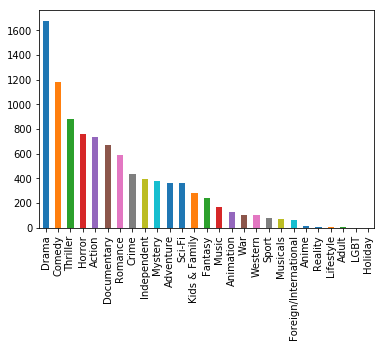

In [12]:
gen_split = df['genres'].str.get_dummies(sep=',').sum()
gen_split.sort_values(ascending=False).plot.bar()

* 'Drama', 'Comedy', 'Thriller' are the top 3 movie genres in the data. 
* 'Anime', 'Reality', Lifestyle', 'Adult', 'LGBT' and 'Holiday' are the 6 least genres in the data. So we plan to combine them into one single genre, 'Other', during feature processing.   

### 1.4.2 Distribution of release year
* The release year of movies varies through a wide range (1916-2017). Considering the popularity of a movie usually decays over time, the release_year should be bucketed based on the release_year range.

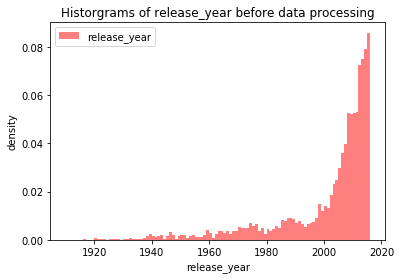

In [13]:
plt.figure(1)
plt.hist(df['release_year'].values, bins = range(1910, 2017, 1), alpha = 0.5, color='r', label = 'release_year', normed = True)
plt.legend(loc ='upper left')
plt.title('Historgrams of release_year before data processing')
plt.xlabel('release_year')
plt.ylabel('density')
plt.show()

### 1.4.3 Other Categorical Variables
* Use strip plots to see the distribution between cvt_per_day and other categorial variables. 

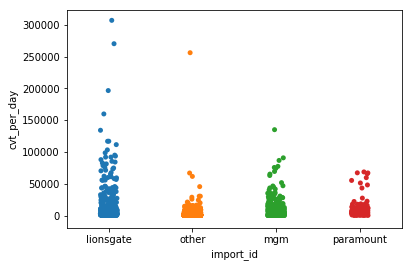

other        2963
lionsgate     677
mgm           445
paramount     141
Name: import_id, dtype: int64


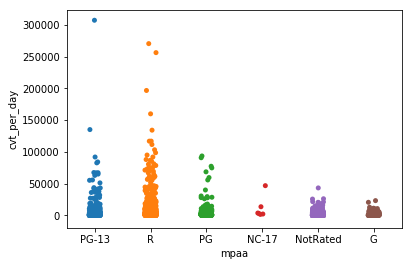

NotRated    2158
R           1158
PG-13        426
PG           353
G            125
NC-17          6
Name: mpaa, dtype: int64


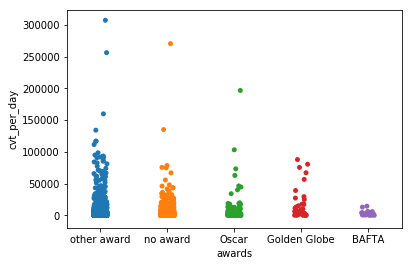

no award        2569
other award     1453
Oscar            141
Golden Globe      44
BAFTA             19
Name: awards, dtype: int64


In [14]:
sns.stripplot(x='import_id', y='cvt_per_day', data=df, jitter=True)
plt.show()
print(df['import_id'].value_counts())

sns.stripplot(x='mpaa', y='cvt_per_day', data=df, jitter=True)
plt.show()
print(df['mpaa'].value_counts())

sns.stripplot(x='awards', y='cvt_per_day', data=df, jitter=True)
plt.show()
print(df['awards'].value_counts())

# Part 2: Feature Preprocessing

## 2.1 Categorical Variables - Convert into dummy variables

There are 5 categorical variables: 
* import_id, 
* mpaa, 
* awards, 
* genres, 
* release_year. 

There is no missing data in them. We will convert them into dummy variables. We use one-hot encoding for the categorical variables. 

The first 3 variables have relatively small sub-types, they can be easily converted to dummy variables. 

Variable 'genres' have 27 different sub-types, 6 of them have low frequencies (refer section 1.4.1). We decide to combine the 6 genres as 'Other'.  Note: a movie may have more than one genre, in the feature preprocessing, all genres are handled individually.

Variable 'release_year' is bined into 10 buckets based on the year range between 1917 and 2017.

In [15]:
# Convert first 3 categorical variables into dummy variables
d_import_id = pd.get_dummies(df['import_id']).astype(np.int64)
d_mpaa = pd.get_dummies(df['mpaa']).astype(np.int64)
d_awards = pd.get_dummies(df['awards']).astype(np.int64)

In [16]:
# Convert genres into dummy variables
d_genres = df['genres'].str.get_dummies(sep=',').astype(np.int64)
# combine 6 smallest genres into a new genre 'Other'. Use bitwise operation '|', then drop these 6 columns.
d_genres['Other'] = d_genres['Anime']|d_genres['Reality']|d_genres['Lifestyle']|d_genres['Adult']|d_genres['LGBT']|d_genres['Holiday']
d_genres.drop(['Anime', 'Reality','Lifestyle', 'Adult','LGBT','Holiday'], inplace=True, axis=1)

In [17]:
d_genres.head(5)

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Fantasy,Foreign/International,Horror,...,Music,Musicals,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,Other
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,1,0,0,0,...,0,0,1,0,0,0,1,1,0,0
4,0,0,0,0,1,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [18]:
# Get the percentiles of release_year.
print(df['release_year'].describe(percentiles = [.1, .2, .3, .4,.5, .6, .7, .8, .9]))

count   4226.000
mean    2001.057
std       17.497
min     1916.000
10%     1974.000
20%     1991.000
30%     2001.000
40%     2006.000
50%     2008.000
60%     2010.000
70%     2012.000
80%     2013.000
90%     2014.000
max     2017.000
Name: release_year, dtype: float64


In [19]:
# bin release_year based on its percentiles and convert into dummies
bin_year = [1916, 1974, 1991, 2001, 2006, 2008, 2010, 2012, 2013, 2014,2017]
year_range = [str(bin_year[i])+'-'+str(bin_year[i+1]) for i in range(len(bin_year)-1)]
year_bin = pd.cut(df['release_year'], bin_year, labels=year_range)
d_year = pd.get_dummies(year_bin).astype(np.int64)

In [20]:
d_year.head(5)

,1916-1974,1974-1991,1991-2001,2001-2006,2006-2008,2008-2010,2010-2012,2012-2013,2013-2014,2014-2017
0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0


In [24]:
# new dataframe, drop the previous categorical features, add new dummy variables, check for null
df_temp = df.drop(['import_id', 'mpaa','awards','genres', 'release_year'], axis=1)
newdf = pd.concat([df_temp, d_import_id, d_mpaa, d_awards, d_genres, d_year], axis=1)
print(newdf.shape)
print(pd.isnull(newdf).any(1).nonzero()[0])
newdf_0 = newdf.copy() # a copy of newdf

(4226, 58)
[]


In [25]:
newdf.head()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,...,1916-1974,1974-1991,1991-2001,2001-2006,2006-2008,2008-2010,2010-2012,2012-2013,2013-2014,2014-2017
0,385504,307127.606,1,3,69614,15000000,42930462,6.500,112.301,51,...,0,0,0,0,0,0,0,1,0,0
1,300175,270338.426,1,3,46705,15000000,3301046,6.500,94.983,41,...,0,0,0,0,0,0,0,1,0,0
2,361899,256165.867,1,3,197596,26000000,37397291,7.300,115.764,58,...,0,0,0,0,0,0,1,0,0,0
3,308314,196622.721,3,4,356339,15000000,15700000,7.600,130.704,94,...,0,0,0,0,1,0,0,0,0,0
4,307201,159841.652,1,3,46720,27220000,8551228,6.400,105.546,37,...,0,0,0,0,0,0,0,1,0,0


The feature space holds 4226 observations and 58 variables. There is NO null data. newdf_0 is kepted as the raw dataframe before any further feature processing, e.g. replace 0 with null, missing data fill etc.

## 2.2 Numerical Variables - Handling of missing data

Among the 10 numerical variables, I found that 4 features (budget, boxoffice, metacritic_score, star_category) have more than 25% missing data (shown as '0', which is not possible in reality), and 2 features (imdb_votes, imdb_rating) have less than 10% of missing data. There are 3242 samples have at least one missing data.

In [27]:
# mark zero values as NaN
newdf[['budget','boxoffice','metacritic_score', 'star_category','imdb_votes', 'imdb_rating']] = newdf[['budget','boxoffice','metacritic_score', 'star_category','imdb_votes', 'imdb_rating']].replace(0, np.nan)

# count the number of NaN values in each column
print(newdf.isnull().sum())

#count the number videos who have at least one missing data 
print('videos having at least one null: ', newdf.isnull().any(axis=1).sum())

video_id                            0
cvt_per_day                         0
weighted_categorical_position       0
weighted_horizontal_poition         0
imdb_votes                        344
budget                           2454
boxoffice                        3194
imdb_rating                       344
duration_in_mins                    0
metacritic_score                 3012
star_category                    1846
lionsgate                           0
mgm                                 0
other                               0
paramount                           0
G                                   0
NC-17                               0
NotRated                            0
PG                                  0
PG-13                               0
R                                   0
BAFTA                               0
Golden Globe                        0
Oscar                               0
no award                            0
other award                         0
Action      

For imdb_voates and imdb_rating, they always show 'null' together, which is reasonable, since when a imdb_votes is missing, the imdb_rating is mostly also missing. For all 6 features with missiong data, the 1st attempt is to fill in with their mean value.

In [28]:
# fill missing values with the column mean
newdf_i1 = newdf.copy()
newdf_i1['budget'].fillna(newdf_i1['budget'].mean(), inplace=True)
newdf_i1['boxoffice'].fillna(newdf_i1['boxoffice'].mean(), inplace=True)
newdf_i1['metacritic_score'].fillna(newdf_i1['metacritic_score'].mean(), inplace=True)
newdf_i1['star_category'].fillna(newdf_i1['star_category'].mean(), inplace=True)
newdf_i1['imdb_votes'].fillna(newdf_i1['imdb_votes'].mean(), inplace=True)
newdf_i1['imdb_rating'].fillna(newdf_i1['imdb_rating'].mean(), inplace=True)

In [29]:
#count the number videos who have at least one missing data 
print('videos having at least one null: ', newdf_i1.isnull().any(axis=1).sum())

videos having at least one null:  0


The imputed dataset newdf_i1 have no missing value. This dataset will be used for the model training process. 

# Part 3: Model Training

## 3.0 Feature Scaling and Train, Test Split

* The impact of different scaling methods on the model performance is small. In the following model training and selection process, the standard scaling method is used. 
* 85% of the samples will be used to train all the models, and 15% is reserved for test the models in next section.

In [30]:
#Standard scaling
scale_lst = ['weighted_categorical_position', 'weighted_horizontal_poition', 'budget','boxoffice', 
             'imdb_votes','imdb_rating','duration_in_mins', 'metacritic_score','star_category']
newdf_sc = newdf_i1.copy()

sc_scale = preprocessing.StandardScaler().fit(newdf_sc[scale_lst])
newdf_sc[scale_lst] = sc_scale.transform(newdf_sc[scale_lst])

newdf_sc.head()

,video_id,cvt_per_day,weighted_categorical_position,weighted_horizontal_poition,imdb_votes,budget,boxoffice,imdb_rating,duration_in_mins,metacritic_score,...,1916-1974,1974-1991,1991-2001,2001-2006,2006-2008,2008-2010,2010-2012,2012-2013,2013-2014,2014-2017
0,385504,307127.606,-1.106,-2.116,1.984,1.470,4.696,0.542,1.079,-0.630,...,0,0,0,0,0,0,0,1,0,0
1,300175,270338.426,-1.106,-2.116,1.258,1.470,-1.022,0.542,0.257,-1.997,...,0,0,0,0,0,0,0,1,0,0
2,361899,256165.867,-1.106,-2.116,6.043,3.108,3.898,1.100,1.243,0.327,...,0,0,0,0,0,0,1,0,0,0
3,308314,196622.721,-0.780,-2.032,11.077,1.470,0.767,1.309,1.952,5.250,...,0,0,0,0,1,0,0,0,0,0
4,307201,159841.652,-1.106,-2.116,1.258,3.290,-0.265,0.472,0.758,-2.544,...,0,0,0,0,0,0,0,1,0,0


In [33]:
# The 15% test data will kept aside, they won't be seen by the models until final test/comparison.

from sklearn.model_selection import train_test_split
model_train, model_test = train_test_split(newdf_sc, test_size=0.15, random_state = 3)
model_train_x = model_train.drop(['video_id', 'cvt_per_day'], axis = 1)
model_test_x = model_test.drop(['video_id', 'cvt_per_day'], axis = 1)
model_train_y = model_train['cvt_per_day']
model_test_y = model_test['cvt_per_day']

## 3.1 Linear Models

In [83]:
lr_train, lr_validate = train_test_split(model_train, test_size=0.15, random_state = 0)

lr_train_x = lr_train.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_validate_x = lr_validate.drop(['video_id', 'cvt_per_day'], axis = 1)
lr_train_y = lr_train['cvt_per_day']
lr_validate_y = lr_validate['cvt_per_day']

### 3.1.1 LASSO Linear Regression

**1) All features are linear**

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

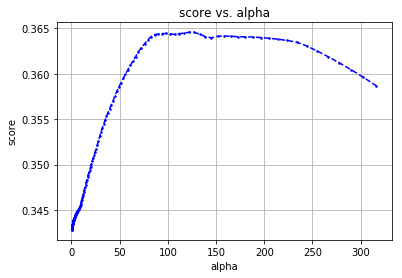

The optimaized alpha and score of Lasso linear is:  122.06107238906554 0.36457853302954235


In [114]:
alphas = np.logspace (-0.3, 2.5, num=150)
scores = np.empty_like(alphas)
opt_lasso_f = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha = a)
    lasso.fit(lr_train_x, lr_train_y)
    scores[i] = lasso.score(lr_validate_x, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_lasso_f = a
        
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='.',markerfacecolor='blue', markersize=3)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print('The optimaized alpha and score of Lasso linear is: ', opt_lasso_f, max_score)

In [110]:
# combine the validate data and training data, use the optimal alpha, re-train the model
lasso_f = Lasso()
lasso_f.set_params(alpha = opt_lasso_f)
lasso_f.fit(model_train_x, model_train_y)

# lasso_f is the final Lasso model (linear feature), to be tested with final test data.

Lasso(alpha=122.06107238906554, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

**2) LASSO Regression with Polynomial features**

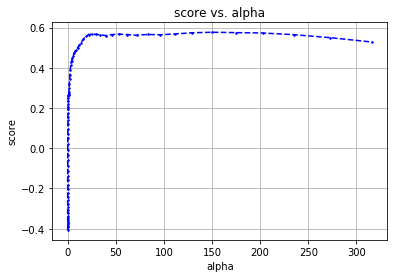

The optimaized alpha and score of Lasso polynomial is:  150.38869469554086 0.5764936326091715


In [119]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

lr_train_xp = poly.fit_transform(lr_train_x)
lr_validate_xp = poly.fit_transform(lr_validate_x)

alphas = np.logspace (-2.6, 2.5, num=80)
scores = np.empty_like(alphas)
opt_lasso_fp = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    lasso = Lasso()
    lasso.set_params(alpha = a)
    lasso.fit(lr_train_xp, lr_train_y)
    scores[i] = lasso.score(lr_validate_xp, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_lasso_fp = a
        
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='.',markerfacecolor='blue', markersize=3)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print('The optimaized alpha and score of Lasso polynomial is: ', opt_lasso_fp, max_score)

In [143]:
# combine the validate data and training data, use the optimal alpha, re-train the model
lr_train_xp1 = poly.fit_transform(model_train_x)

lasso_fp = Lasso(max_iter=2000)
lasso_fp.set_params(alpha = opt_lasso_fp)
lasso_fp.fit(lr_train_xp1, model_train_y)

# lasso_fp is the final Lasso model (with polynomial feature), to be tested with test data.

Lasso(alpha=150.38869469554086, copy_X=True, fit_intercept=True,
   max_iter=2000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

### 3.1.2 Ridge Linear Regression

**1) All features are linear**

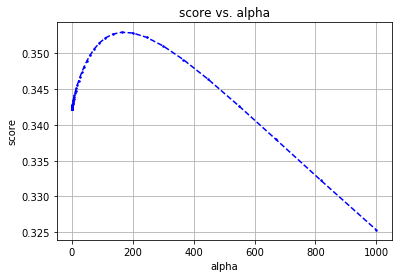

The optimaized alpha and score of Ridge linear is:  163.97026580002054 0.3529604309849165


In [121]:
alphas = np.logspace (-10, 3, num=150)
scores = np.empty_like(alphas)
opt_ridge_f = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    ridge = Ridge()
    ridge.set_params(alpha = a)
    ridge.fit(lr_train_x, lr_train_y)
    scores[i] = ridge.score(lr_validate_x, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_ridge_f = a
        
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='.',markerfacecolor='blue', markersize=3)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print('The optimaized alpha and score of Ridge linear is: ', opt_ridge_f, max_score)

In [122]:
# combine the validate data and training data, use the optimal alpha, re-train the model

ridge_f = Ridge()
ridge_f.set_params(alpha = opt_ridge_f)
ridge_f.fit(model_train_x, model_train_y)

# ridge_f is the final Ridge model (linear feature), to be tested with test data.

Ridge(alpha=163.97026580002054, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

**2) Ridge Regression with Polynomial features**

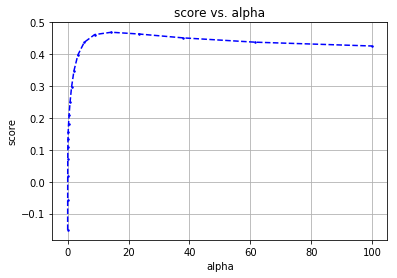

The optimaized alpha and score of Ridge polynomial is:  14.38449888287663 0.46816918700192844


In [123]:
alphas = np.logspace (-2, 2, num=20)
scores = np.empty_like(alphas)
opt_ridge_fp = float('-inf')
max_score = float('-inf')
for i, a in enumerate(alphas):
    ridge = Ridge()
    ridge.set_params(alpha = a)
    ridge.fit(lr_train_xp, lr_train_y)
    scores[i] = ridge.score(lr_validate_xp, lr_validate_y)
    if scores[i] > max_score:
        max_score = scores[i]
        opt_ridge_fp = a
        
plt.plot(alphas, scores, color='b', linestyle='dashed', marker='.',markerfacecolor='blue', markersize=3)
plt.xlabel('alpha')
plt.ylabel('score')
plt.grid(True)
plt.title('score vs. alpha')
plt.show()
print('The optimaized alpha and score of Ridge polynomial is: ', opt_ridge_fp, max_score)

In [124]:
# combine the validate data and training data, use the optimal alpha, re-train the model
ridge_fp = Ridge()
ridge_fp.set_params(alpha = opt_ridge_fp)
ridge_fp.fit(lr_train_xp1, model_train_y)

# ridge_fp is the final Ridge model (with polynomial feature), to be tested with test data.

Ridge(alpha=14.38449888287663, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

## 3.2 Non-Linear Models

Random forest regressor with Gridsearch cross-validation is used. The 'mean_scores' is used to find the best paramenters of n_estimator (number of trees in the forest) and max_depth (maximum depth of the tree).

In [100]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

rf_train, rf_validate = train_test_split(model_train, test_size=0.15, random_state = 0)

rf_train_x = rf_train.drop(['video_id', 'cvt_per_day'], axis = 1)
rf_validate_x = rf_test.drop(['video_id', 'cvt_per_day'], axis = 1)
rf_train_y = rf_train['cvt_per_day']
rf_validate_y = rf_test['cvt_per_day']

param_grid = {
                 'n_estimators': [54, 55, 56, 57, 58, 59, 60],
                 'max_depth': [12, 13, 14, 15, 16, 17]
             }

rf = RandomForestRegressor(random_state=2, max_features = 'sqrt')
grid_rf = GridSearchCV(rf, param_grid, cv=5)
grid_rf.fit(rf_train_x, rf_train_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=2, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [54, 55, 56, 57, 58, 59, 60], 'max_depth': [12, 13, 14, 15, 16, 17]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [101]:
grid_rf.best_params_ 

{'max_depth': 14, 'n_estimators': 55}

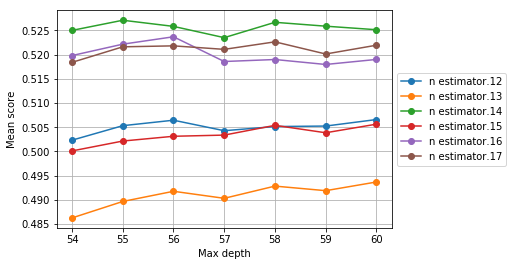

In [102]:
# plot the effect of different number of trees and maximum tree-depth druing cross validation 
scores = grid_rf.cv_results_['mean_test_score']

n_est = [54, 55, 56, 57, 58, 59, 60]
m_depth=[12, 13, 14, 15, 16, 17]
scores = np.array(scores).reshape(len(m_depth), len(n_est))
fig = plt.figure()
ax = plt.subplot(111)
for ind, i in enumerate(m_depth):
    plt.plot(n_est, scores[ind], '-o', label='n estimator.' + str(i),)
    
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Max depth')
plt.ylabel('Mean score')
plt.grid(True)
plt.show()

In [135]:
# combine the validate data and training data, use the optimal alpha, re-train the model
rf_f = RandomForestRegressor(random_state=2, max_features = 'sqrt', max_depth= 14, n_estimators=55)
rf_f.fit(model_train_x, model_train_y)

# rf_f is the final Random Forest Regression model, to be tested with test data.

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=55, n_jobs=1,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

# Part 4: Model Evaluation

Test data is the reserved 15% of the whole dataset (model_test_x, model_test_y), and has never been used during the model training process. The model was evaluated using 3 metrics: RSS score, mean square error, and root mean squared error.

## 4.1 Test LASSO model with linear features (lasso_f)

In [125]:
# Lasso_f test (with only linear features)

lasso_f_score = lasso_f.score(model_test_x, model_test_y)
pred_y = lasso_f.predict(model_test_x)

# The mean squared error and root mean square error
MSE_lasso_f = mean_squared_error(model_test_y, pred_y)
RMSE_lasso_f = sqrt(mean_squared_error(model_test_y, pred_y))

print('lasso_f score: ', lasso_f_score)
print('Mean square error of lasso_f: ', MSE_lasso_f)
print ('Root mean squared error of lasso_f:', RMSE_lasso_f)
# print ('Coefficients of lasso_f: ', lasso_f.coef_)

lasso_f score:  0.09954927178753703
Mean square error of lasso_f:  238953191.99910036
Root mean squared error of lasso_f: 15458.110880670392


## 4.2 Test LASSO model with polynomial features (lasso_fp)

In [145]:
# Lasso_fp test (with polynomial features)
model_test_xp = poly.fit_transform(model_test_x)
pred_y = lasso_fp.predict(model_test_xp)

lasso_fp_score = lasso_fp.score(model_test_xp, model_test_y)
MSE_lasso_fp = mean_squared_error(model_test_y, pred_y)
RMSE_lasso_fp = sqrt(mean_squared_error(model_test_y, pred_y))

print('lasso_fp score: ', lasso_fp_score)
print('Mean square error of lasso_fp: ', MSE_lasso_fp)
print('Root mean squared error of lasso_fp:', RMSE_lasso_fp)
# print ('Coefficients of lasso_fp: ', lasso_fp.coef_)

lasso_fp score:  -0.08392274794825783
Mean square error of lasso_fp:  287641280.51386213
Root mean squared error of lasso_fp: 16959.990581184356


## 4.3 Test Ridge model with linear features (ridge_f)

In [140]:
# ridge_f test (with linear features)

ridge_f_score = ridge_f.score(model_test_x, model_test_y)
pred_y = ridge_f.predict(model_test_x)

# The mean squared error and root mean square error
MSE_ridge_f = mean_squared_error(model_test_y, pred_y)
RMSE_ridge_f = sqrt(mean_squared_error(model_test_y, pred_y))

print ('ridge_f score: ', ridge_f_score)
print ('Mean square error of ridge_f: ', MSE_ridge_f)
print ('Root mean squared error of ridge_f:', RMSE_ridge_f)
# print ('Coefficients of ridge_f: ', ridge_f.coef_)

ridge_f score:  0.11371374943726796
Mean square error of ridge_f:  235194355.40609524
Root mean squared error of ridge_f: 15336.047580980416


## 4.4 Test Ridge model with polynomial features (ridge_fp)

In [132]:
# ridge_fp test (with polynomial features)
model_test_xp = poly.fit_transform(model_test_x)

ridge_fp_score = ridge_fp.score(model_test_xp, model_test_y)
MSE_ridge_fp = mean_squared_error(model_test_y, pred_y)
RMSE_ridge_fp = sqrt(mean_squared_error(model_test_y, pred_y))

pred_y = ridge_fp.predict(model_test_xp)
print ('ridge_fp score: ', ridge_fp_score)
print ('Mean square error of ridge_fp: ', MSE_ridge_fp)
print ('Root mean squared error of ridge_fp:', RMSE_ridge_fp)
#print ('Coefficients of ridge_fp: ', ridge_fp.coef_)

ridge_fp score:  0.3803378913673322
Mean square error of ridge_fp:  164440134.45645392
Root mean squared error of ridge_fp: 12823.421324141773


## 4.5 Test Random Forest Regressor (rf_f)

In [137]:
rf_score = rf_f.score(model_test_x, model_test_y)

pred_y = rf_f.predict(model_test_x)
MSE_rf = mean_squared_error(model_test_y, pred_y)
RMSE_rf = sqrt(mean_squared_error(model_test_y, pred_y))

# The mean squared error and root mean square error
print ('rf score: ', rf_score)
print ('Mean square error of rf: ', MSE_rf)
print ('Root mean squared error of rf:', RMSE_rf)
# print('Coefficients: \n', ridge_fp.coef_)

rf score:  0.5165908876551256
Mean square error of rf:  128282588.72705819
Root mean squared error of rf: 11326.190388963898


## 4.6 Comparison of the 5 models

Compared the RSS score, mean squared error (MSE), and root mean squared error (RMSE) of 5 models. Random forest model rf_f returns the beset prediction accuracy.

In [146]:
comparison_data = {
    'Model Name': ['Lasso_linear','Lasso poly', 'Ridge linear', 'Ridge poly', 'Random forest'],
    'RSS score': [lasso_f_score, lasso_fp_score, ridge_f_score, ridge_fp_score, rf_score],
    'MSE': [MSE_lasso_f, MSE_lasso_fp, MSE_ridge_f, MSE_ridge_fp, MSE_rf],
    'RMSE': [RMSE_lasso_f, RMSE_lasso_fp, RMSE_ridge_f, RMSE_ridge_fp, RMSE_rf]
}
df_compare = pd.DataFrame(data=comparison_data, columns = ['Model Name', 'RSS score', 'MSE', 'RMSE'])
df_compare

,Model Name,RSS score,MSE,RMSE
0,Lasso_linear,0.100,238953191.999,15458.111
1,Lasso poly,-0.084,287641280.514,16959.991
2,Ridge linear,0.114,235194355.406,15336.048
3,Ridge poly,0.380,164440134.456,12823.421
4,Random forest,0.517,128282588.727,11326.190


# Part 5: Feature Importance

Random forest(RF) shows the best prediction accuracy. Therefore, the feature importance will be extracted from the RF model.

Feature importance ranking:
1. feature 0 weighted_categorical_position (0.151490)
2. feature 2 weighted_horizontal_poition (0.133391)
3. feature 1 imdb_votes (0.112314)
4. feature 3 budget (0.070595)
5. feature 7 boxoffice (0.060027)
6. feature 8 imdb_rating (0.051750)
7. feature 4 duration_in_mins (0.051296)
8. feature 6 metacritic_score (0.039816)
9. feature 9 star_category (0.036208)
10. feature 11 lionsgate (0.030517)
11. feature 5 mgm (0.027920)
12. feature 10 other (0.019769)
13. feature 53 paramount (0.019051)
14. feature 52 G (0.015720)
15. feature 18 NC-17 (0.013947)
16. feature 28 NotRated (0.013426)
17. feature 49 PG (0.010542)
18. feature 23 PG-13 (0.009500)
19. feature 42 R (0.009128)
20. feature 22 BAFTA (0.007116)
21. feature 38 Golden Globe (0.006958)
22. feature 30 Oscar (0.006782)
23. feature 27 no award (0.006641)
24. feature 50 other award (0.006127)
25. feature 15 Action (0.005960)
26. feature 48 Adventure (0.005511)
27. feature 17 Animation (0.005243)
28. feature 

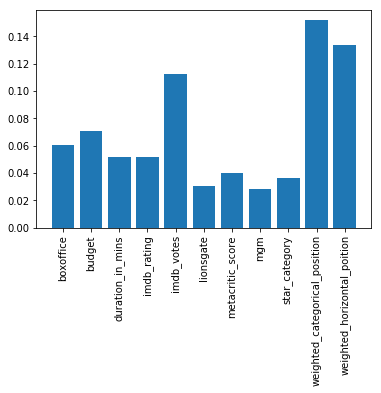

In [149]:
importances = rf_f.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_f.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
feature_name = model_test_x.columns.get_values()

# Print the feature ranking
print("Feature importance ranking:")

for f in range(model_test_x.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f],  feature_name[f], importances[indices[f]]))
    
plt.figure(1)
plt.bar(feature_name[:11], importances[indices[:11]])
plt.xticks(rotation=90)
plt.show()

The top 3 strongest predictors are: 'weighted_categorical_position', 'weighted_horizontal_poition' and 'imdb_votes'. 